# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1050 Ti (CNMeM is disabled, cuDNN not available)


All data get stored in a python object InputData. Therefore we can use python serialization to save the input of the models. In the next chapter we will see different ways to create data but for this example we will use a stored one

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv",
                         path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

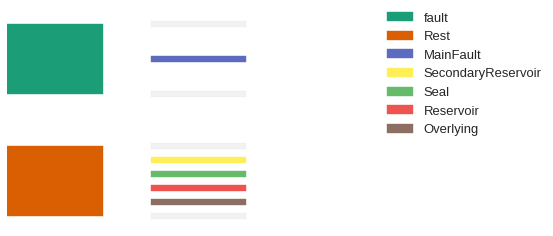

In [4]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ])

In [5]:
geo_data.foliations

X       Y         Z  azimuth     dip  polarity  formation series  \
0   917.45  1000.0 -1135.398    270.0  71.565         1  MainFault  fault   
1  1450.00  1000.0 -1150.000     90.0  18.435         1  Reservoir   Rest   

   order_series  formation number                      annotations       G_x  \
0             1                 1  ${\bf{x}}_{\beta \,{\bf{1}},0}$ -0.948683   
1             2                 4  ${\bf{x}}_{\beta \,{\bf{4}},0}$  0.316229   

            G_y       G_z  isFault  
0 -1.742702e-16  0.316229     True  
1  1.936342e-17  0.948683    False

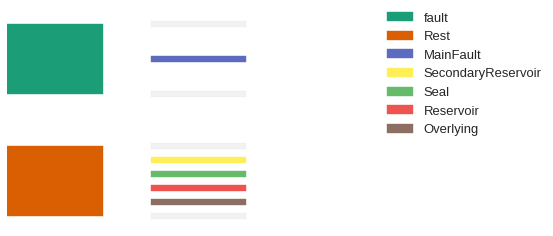

In [6]:
%matplotlib inline
gp.get_stratigraphic_pile(geo_data)

This geo_data object contains essential information that we can access through the correspondent getters. Such a the coordinates of the grid.

In [7]:
print(gp.get_grid(geo_data))

[[    0.             0.         -2000.        ]
 [    0.             0.         -1959.18371582]
 [    0.             0.         -1918.36730957]
 ..., 
 [ 2000.          2000.           -81.63265228]
 [ 2000.          2000.           -40.81632614]
 [ 2000.          2000.             0.        ]]


The main input the potential field method is the coordinates of interfaces points as well as the orientations. These pandas dataframes can we access by the following methods:

#### Interfaces Dataframe

In [8]:
gp.get_data(geo_data, 'interfaces').head()

X     Y     Z  formation series                       annotations
0  1000  1000 -1000  MainFault  fault  ${\bf{x}}_{\alpha \,{\bf{1}},0}$
1   800  1000 -1600  MainFault  fault  ${\bf{x}}_{\alpha \,{\bf{1}},1}$
2  1200  1000  -400  MainFault  fault  ${\bf{x}}_{\alpha \,{\bf{1}},2}$
3  1100  1000  -700  MainFault  fault  ${\bf{x}}_{\alpha \,{\bf{1}},3}$
4   900  1000 -1300  MainFault  fault  ${\bf{x}}_{\alpha \,{\bf{1}},4}$

#### Foliations Dataframe

In [9]:
gp.get_data(geo_data, 'foliations').head()

X       Y         Z     dip  azimuth  polarity  formation series  \
0   917.45  1000.0 -1135.398  71.565    270.0         1  MainFault  fault   
1  1450.00  1000.0 -1150.000  18.435     90.0         1  Reservoir   Rest   

                       annotations  
0  ${\bf{x}}_{\beta \,{\bf{1}},0}$  
1  ${\bf{x}}_{\beta \,{\bf{4}},0}$

It is important to notice the columns of each data frame. These not only contains the geometrical properties of the data but also the **formation** and **series** at which they belong. This division is fundamental in order to preserve the depositional ages of the setting to model.

A projection of the aforementioned data can be visualized in to 2D by the following function. It is possible to choose the direction of visualization as well as the series:

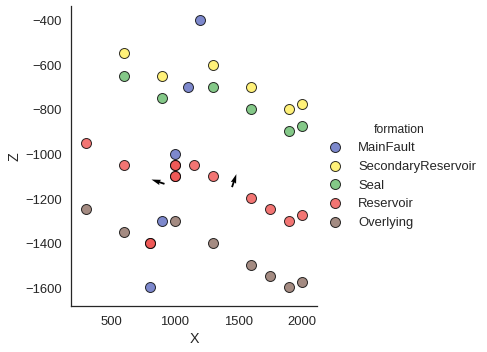

In [10]:
%matplotlib inline
geo_data.geo_data_type= 3
gp.plot_data(geo_data, direction='y')

GemPy supports visualization in 3D as well trough vtk.

In [11]:
gp.plot_data_3D(geo_data)

## The ins and outs of Input data objects

As we have seen objects DataManagement.InputData (usually called geo_data in the tutorials) aim to have all the original geological properties, measurements and geological relations stored. 

Once we have the data ready to generate a model, we will need to create the next object type towards the final geological model:

In [12]:
interp_data = gp.InterpolatorInput(geo_data,# u_grade = [3],
                                   verbose=['faults_block'])
print(interp_data)

Level of Optimization:  fast_run
Device:  gpu
Precision:  float32


In [13]:
interp_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 5,
 'Reservoir': 4,
 'Seal': 3,
 'SecondaryReservoir': 2}


By default (there is a flag in case you do not need) when we create a interp_data object we also compile the theano function that compute the model. That is the reason why takes long.

gempy.DataManagement.InterpolatorInput (usually called interp_data in the tutorials) prepares the original data to the interpolation algorithm by scaling the coordinates for better and adding all the mathematical parametrization needed.


In [14]:
gp.get_kriging_parameters(interp_data)

range 0.8882311582565308 3464.1015172
Number of drift equations [2 2]
Covariance at 0 0.01878463476896286
Foliations nugget effect 0.009999999776482582


 These later parameters have a default value computed from the original data or can be changed by the user (be careful of changing any of these if you do not fully understand their meaning).
 
At this point, we have all what we need to compute our model. By default everytime we compute a model we obtain 3 results:

- Lithology block model
- The potential field
- Faults network block model

In [15]:
lith_block, fault_block = gp.compute_model(interp_data)

This solution can be plot with the correspondent plotting function. Blocks:

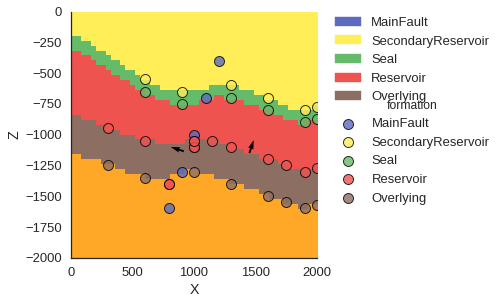

In [16]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 25, plot_data=True)

Potential field:

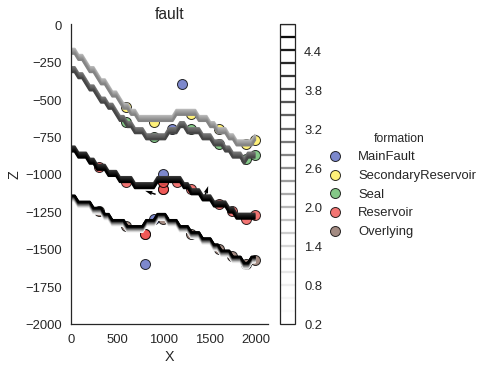

In [17]:
gp.plot_potential_field(geo_data, lith_block[0], 25)
import matplotlib.pyplot as plt
plt.colorbar()

In [18]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)

In [19]:
gp.plot_surfaces_3D(geo_data, ver, sim, alpha=1)

In [20]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=False)

In [21]:
gp.plot_surfaces_3D_real_time(interp_data, ver_s, sim_s)

In [22]:
geo_data.foliations

X       Y         Z  azimuth     dip  polarity  formation series  \
0   917.45  1000.0 -1135.398    270.0  71.565         1  MainFault  fault   
1  1450.00  1000.0 -1150.000     90.0  18.435         1  Reservoir   Rest   

   order_series  formation number                      annotations       G_x  \
0             1                 1  ${\bf{x}}_{\beta \,{\bf{1}},0}$ -0.948683   
1             2                 4  ${\bf{x}}_{\beta \,{\bf{4}},0}$  0.316229   

            G_y       G_z  isFault  
0 -1.742702e-16  0.316229     True  
1  1.936342e-17  0.948683    False

In [25]:
gp.plot_data_3D(geo_data)